In [5]:
import cv2
import os
import numpy as np
import uuid
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
# import Arduino.connectArduino as arduino
import serial
import time
import serial.tools.list_ports

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\d3d9ff62-b3ea-11ef-b1ae-38d57a8690c7.jpg'

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

dir_test = anchor.as_numpy_iterator()

print(dir_test.next())

b'data\\anchor\\ffb0c9a3cc3d75632c2c.jpg'


In [8]:
def preprocess(file_path):
    # Đọc hình ảnh từ đường dẫn tệp
    byte_img = tf.io.read_file(file_path)
    # Giải mã hình ảnh từ dạng JPEG
    img = tf.io.decode_jpeg(byte_img)
    
    # Các bước tiền xử lý - thay đổi kích thước hình ảnh về 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Chuẩn hóa hình ảnh để giá trị nằm trong khoảng từ 0 đến 1
    img = img / 255.0

    # Trả về hình ảnh đã được xử lý
    return img

In [9]:
img = preprocess('data\\anchor\\417ba4e0-92e2-11ef-b562-b3ffed7185e3.jpg')
img.numpy().max() 

0.97745097

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()

exampple = samples.next()

In [11]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
res = preprocess_twin(*exampple)

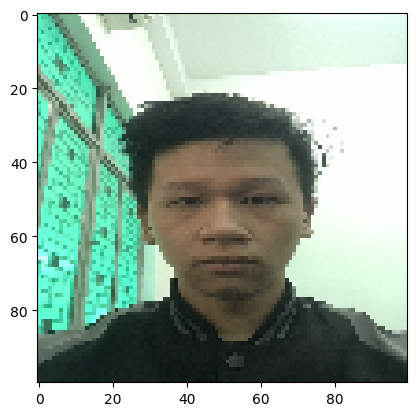

In [ ]:
# plt.imshow(res[1])


In [13]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

inp = Input(shape=(100,100,3), name='input_image')


c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [14]:
def make_embedding(): 
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=inp, outputs=d1, name='embedding')
embedding = make_embedding()

In [14]:
# embedding.summary()


In [15]:
class L1Dist(Layer):   
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [16]:
l1 = L1Dist()

input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

siamese_layer = L1Dist()

distances = siamese_layer(inp_embedding, val_embedding)


classifier = Dense(1, activation='sigmoid')(distances)

siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [17]:
# siamese_network.summary()

In [17]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [18]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

test_batch = train_data.as_numpy_iterator()

batch_1 = test_batch.next()

X = batch_1[:2]
y = batch_1[2]
y
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# EPOCHS = 50
# train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
4/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
0.6267115 0.88372093 1.0

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
0.34700733 0.94871795 1.0

 Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
5/5 ━━━━━━━━━━━━━━━━━━

In [28]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

# Tạo một đối tượng metric Recall
m = Recall()

# Tính toán giá trị recall
m.update_state(y_true, y_hat)

# Trả về kết quả Recall
m.result().numpy()
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0.25 0.71428573


In [29]:
siamese_model.save('siamesemodelv2.h5')

In [24]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [30]:
siamese_model.predict([test_input, test_val])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([[0.50004506]], dtype=float32)

In [31]:
os.listdir(os.path.join('application_data', 'verification_images'))

os.path.join('application_data', 'input_image', 'input_image.jpg')

for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\2a4f17b380f53bab62e4.jpg
application_data\verification_images\3d1b650e6090d9ce8081.jpg
application_data\verification_images\689ef759601fdb41820e.jpg
application_data\verification_images\b40f0eb462f5d9ab80e4.jpg


In [32]:
def verify(model, detection_threshold, verification_threshold):
    # Tạo mảng kết quả
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Dự đoán
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Ngưỡng phát hiện: Chỉ số trên đó một dự đoán được coi là dương
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Ngưỡng xác minh: Tỷ lệ dự đoán dương / tổng số mẫu dương
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# Chay App

In [34]:
cap = cv2.VideoCapture(0)  # Mở kết nối đến webcam
while cap.isOpened():  # Khi webcam mở
    ret, frame = cap.read()  # Đọc khung hình từ webcam
    frame = frame[120:120+250, 200:200+250, :]  # Cắt khung hình thành kích thước 250x250px
    
    cv2.imshow('Verification', frame)  # Hiển thị khung hình trong cửa sổ 'Verification'
    
    # Kích hoạt xác minh
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Lưu hình ảnh đầu vào vào thư mục application_data/input_image
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Thực hiện xác minh
        results, verified = verify(siamese_model, 0.5, 0.5)
        
        # arduino
        
        # ports = serial.tools.list_ports.comports()
        # for port in ports:
        #     print(port)

        # # Kết nối với Arduino qua cổng Serial (thay 'COM3' bằng cổng Serial của bạn)
        # try:
        #     ser = serial.Serial('COM4', 9600)  # Chọn tốc độ baud tương ứng với Arduino (9600)
        #     time.sleep(2)  # Chờ một chút để Arduino khởi động
        # except serial.SerialException as e:
        #     print(f"Lỗi mở cổng: {e}")
        #     exit(1)

        # def send_signal_to_microcontroller(detected):
        #     if detected:
        #         ser.write(b'1')  # Gửi giá trị '1' khi nhận diện khuôn mặt
        #         print("Đã gửi tín hiệu: 1")
        #     else:
        #         ser.write(b'0')  # Gửi giá trị '0' nếu không nhận diện
        #         print("Đã gửi tín hiệu: 0")
        #     time.sleep(1)  # Dừng 1 giây để đảm bảo tín hiệu được truyền đi

        face_detected = verified  # Đặt thành True nếu nhận diện được khuôn mặt
        # send_signal_to_microcontroller(face_detected)

        # ser.close()
        
        #---
        
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):  # Nếu nhấn 'q', thoát khỏi vòng lặp
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
False
